this notebooks shows low level models in which ach neuron to neuron connection is explicity mentioned.

In these examples, we connect a pre population to a post population with different sets of specified connection weights.

installing libraries...

In [2]:
!pip install nengo --quiet
!pip install nengo-dl --quiet
!pip install nengo-loihi --quiet
!pip install nengo-extras==0.5.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 1.8 MB/s eta 0:00:00


importing libraries

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_loihi

## **Simple fan-out**

In this example, a neuron is connected to several downstream neurons with increasing synaptic strength.

Synaptic strengths are defined through the transform of a nengo.Connection. While a Connection between two ensembles operates on their vector representations, a connection between two ensemble’s neuron values operates directly on neural activities (i.e., spikes).

In [4]:
with nengo.Network() as model:
    pre = nengo.Ensemble(1, dimensions=1, gain=[1], bias=[1.05])
    post = nengo.Ensemble(6, dimensions=1, gain=np.ones(6), bias=np.zeros(6))

    transform = np.linspace(0.01, 0.15, post.n_neurons)
    transform = transform.reshape((post.n_neurons, pre.n_neurons))
    nengo.Connection(pre.neurons, post.neurons, transform=transform)

    pre_probe = nengo.Probe(pre.neurons)
    post_probe = nengo.Probe(post.neurons)

## **Running the network in Nengo**

In [5]:
with nengo.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()

ERROR:nengo.cache:Decoder cache index corrupted. Reinitializing cache.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/nengo/cache.py", line 462, in __enter__
    self._load_index_file()
  File "/usr/local/lib/python3.10/dist-packages/nengo/cache.py", line 385, in _load_index_file
    with self.index_path.open("rb") as f:
  File "/usr/lib/python3.10/pathlib.py", line 1119, in open
    return self._accessor.open(self, mode, buffering, encoding, errors,
FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/nengo/decoders/index'
/usr/local/lib/python3.10/dist-packages/nengo/neurons.py:584: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

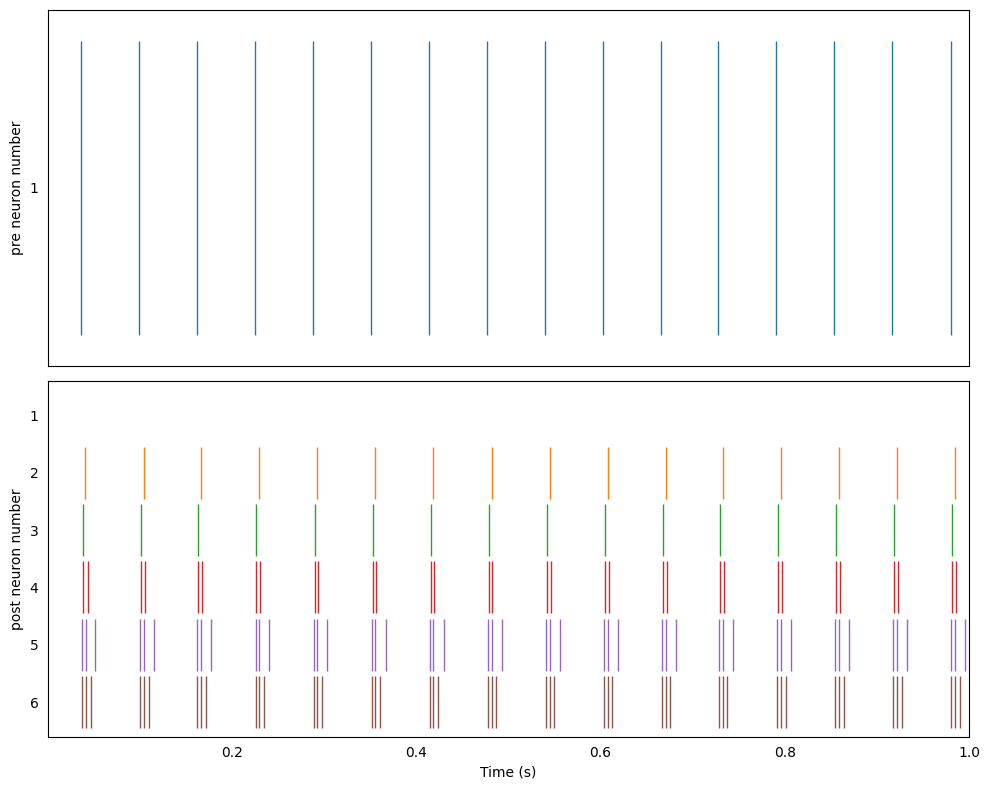

In [6]:
def plot_rasters(t, data):
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    rasterplot(t, data[pre_probe])
    plt.xticks(())
    plt.ylabel("pre neuron number")
    plt.subplot(2, 1, 2)
    rasterplot(t, data[post_probe])
    plt.ylabel("post neuron number")
    plt.xlabel("Time (s)")
    plt.tight_layout()


plot_rasters(t, sim.data)

## **Running the network with NengoLoihi**

In [7]:
with nengo_loihi.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()

/usr/local/lib/python3.10/dist-packages/nengo_loihi/builder/ensemble.py:164: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on LIF neurons. On the chip, all values will be initialized to zero.
  warnings.warn(


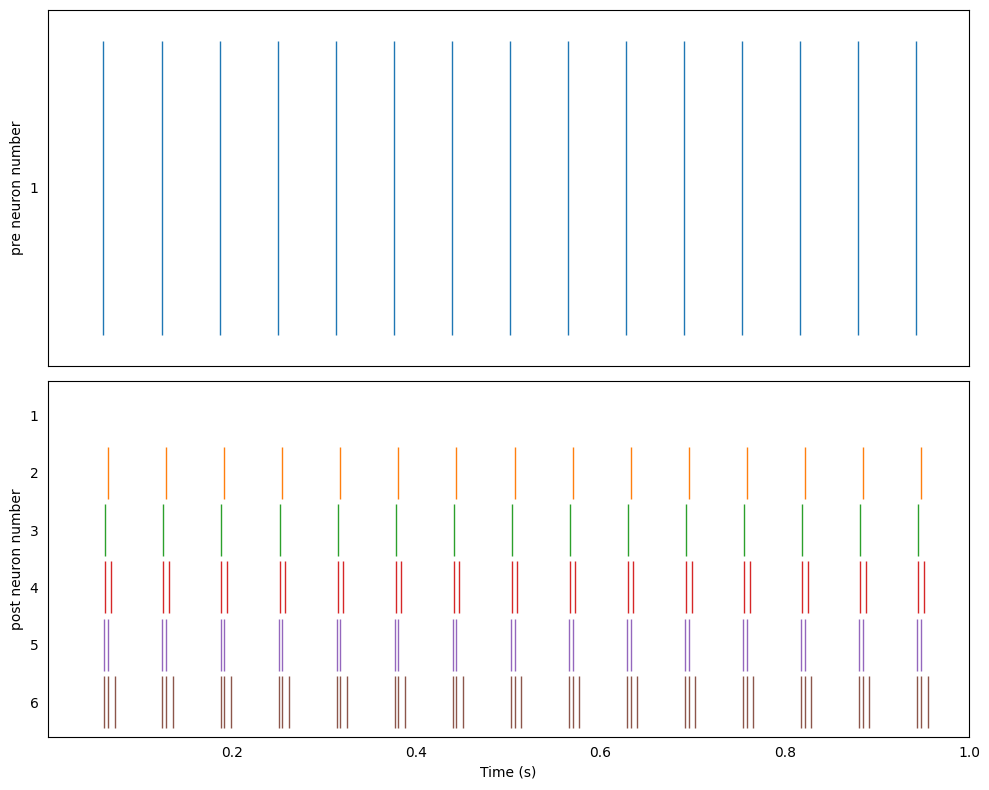

In [8]:
plot_rasters(t, sim.data)

## **One-to-one connections**

In this example, two populations of equal size are connected one-to-one with random biases in the pre population and random excitatory connection weights.

In [9]:
rng = np.random.RandomState(seed=10)
n_neurons = 5

with nengo.Network() as model:
    pre = nengo.Ensemble(
        n_neurons,
        1,
        gain=np.ones(n_neurons),
        bias=rng.uniform(low=1.0, high=1.5, size=n_neurons),
    )
    post = nengo.Ensemble(
        n_neurons, 1, gain=np.ones(n_neurons), bias=np.zeros(n_neurons)
    )

    transform = np.zeros((n_neurons, n_neurons))
    di = np.diag_indices(n_neurons)
    transform[di] = rng.uniform(low=0.0, high=0.2, size=n_neurons)
    nengo.Connection(pre.neurons, post.neurons, transform=transform)

    pre_probe = nengo.Probe(pre.neurons)
    post_probe = nengo.Probe(post.neurons)

## Running the network in Nengo

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

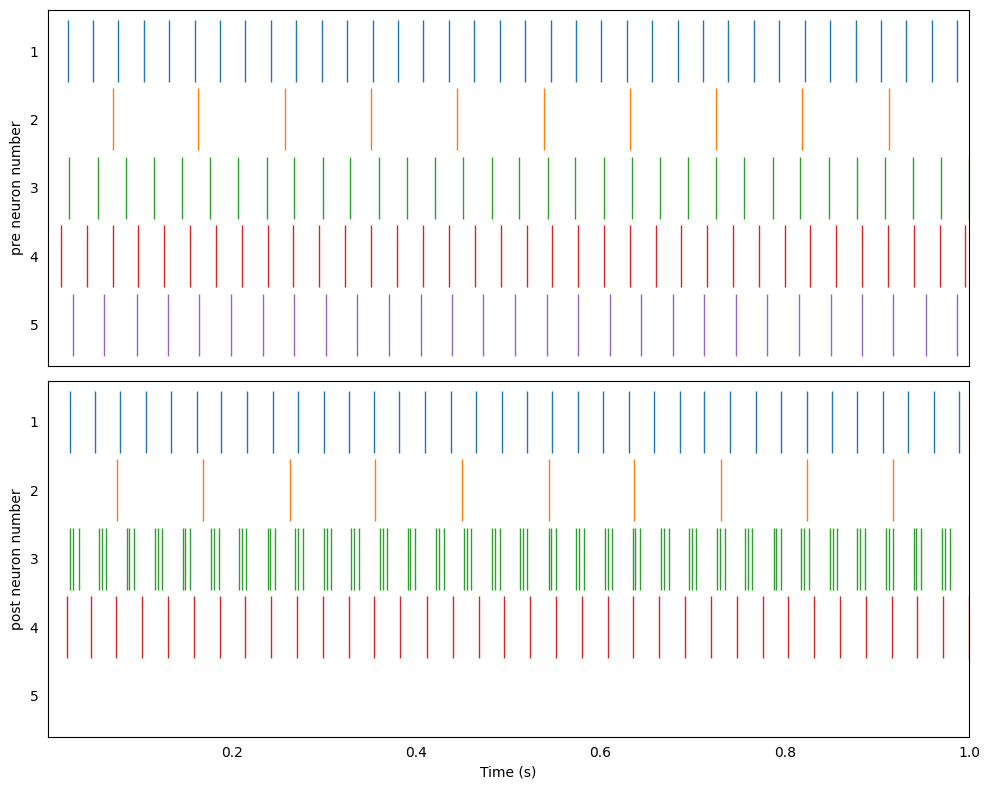

In [10]:
with nengo.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()
plot_rasters(t, sim.data)

## **Running the network with NengoLoihi**

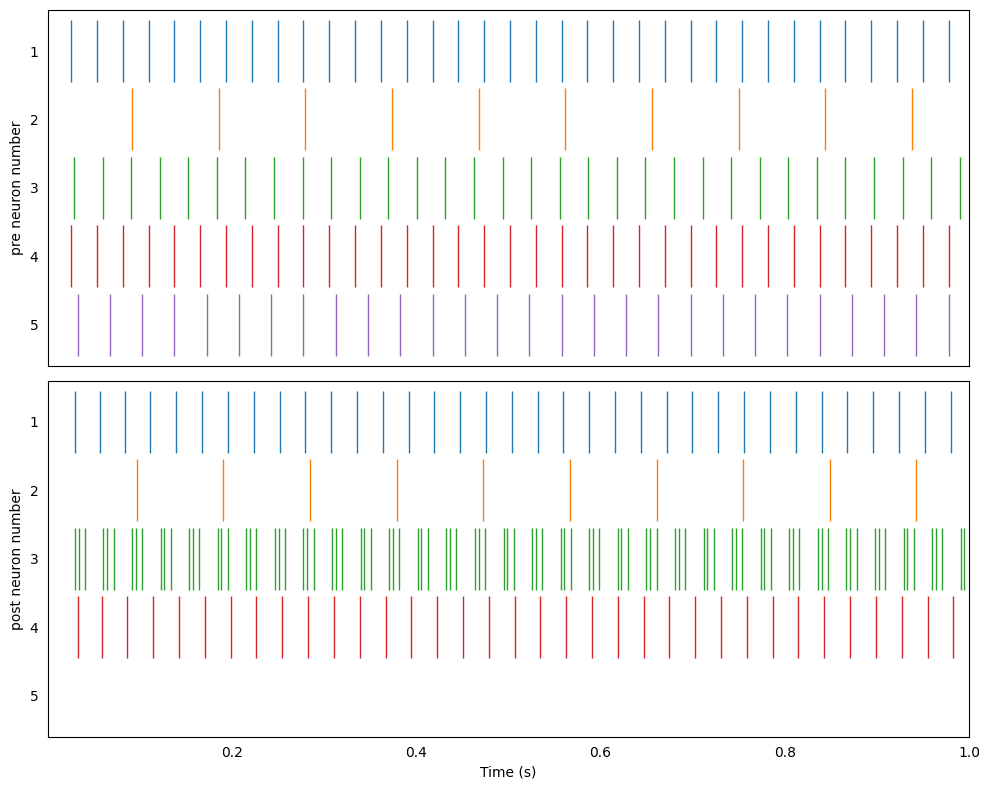

In [11]:
with nengo_loihi.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()
plot_rasters(t, sim.data)

## **Fixed probability connections**

In this example, two populations are recurrently connected (i.e., post is also connected back to pre). There is a fixed probability of two neurons being connected in either direction, a fixed probability of an inhibitory connection, and all connections have the same weight.

In [12]:
rng = np.random.RandomState(seed=100)
inhibitory = 0.5  # 50% inhibitory connections
connection_prob = 0.6  # 60% probability of being connected
n_neurons = 25

with nengo.Network() as model:
    pre = nengo.Ensemble(
        n_neurons,
        1,
        gain=np.ones(n_neurons),
        bias=rng.uniform(low=-2, high=2, size=n_neurons),
    )
    post = nengo.Ensemble(
        n_neurons,
        1,
        gain=np.ones(n_neurons),
        bias=rng.uniform(low=-2, high=2, size=n_neurons),
    )

    pre_post = np.ones((n_neurons, n_neurons)) * 0.05
    # Make some inhibitory
    pre_post[rng.rand(n_neurons, n_neurons) <= inhibitory] *= -1
    # Remove 1 - connection_prob connections
    pre_post[rng.rand(n_neurons, n_neurons) > connection_prob] = 0
    nengo.Connection(pre.neurons, post.neurons, transform=pre_post)

    post_pre = np.ones((n_neurons, n_neurons)) * 0.05
    post_pre[rng.rand(n_neurons, n_neurons) <= inhibitory] *= -1
    post_pre[rng.rand(n_neurons, n_neurons) > connection_prob] = 0
    nengo.Connection(post.neurons, pre.neurons, transform=post_pre)

    pre_probe = nengo.Probe(pre.neurons)
    post_probe = nengo.Probe(post.neurons)

## Running the network in Nengo

/usr/local/lib/python3.10/dist-packages/nengo/neurons.py:584: RuntimeWarning: invalid value encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))
/usr/local/lib/python3.10/dist-packages/nengo/neurons.py:587: UserWarning: Non-finite values detected in `max_rates`; this probably means that `gain` was too small.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

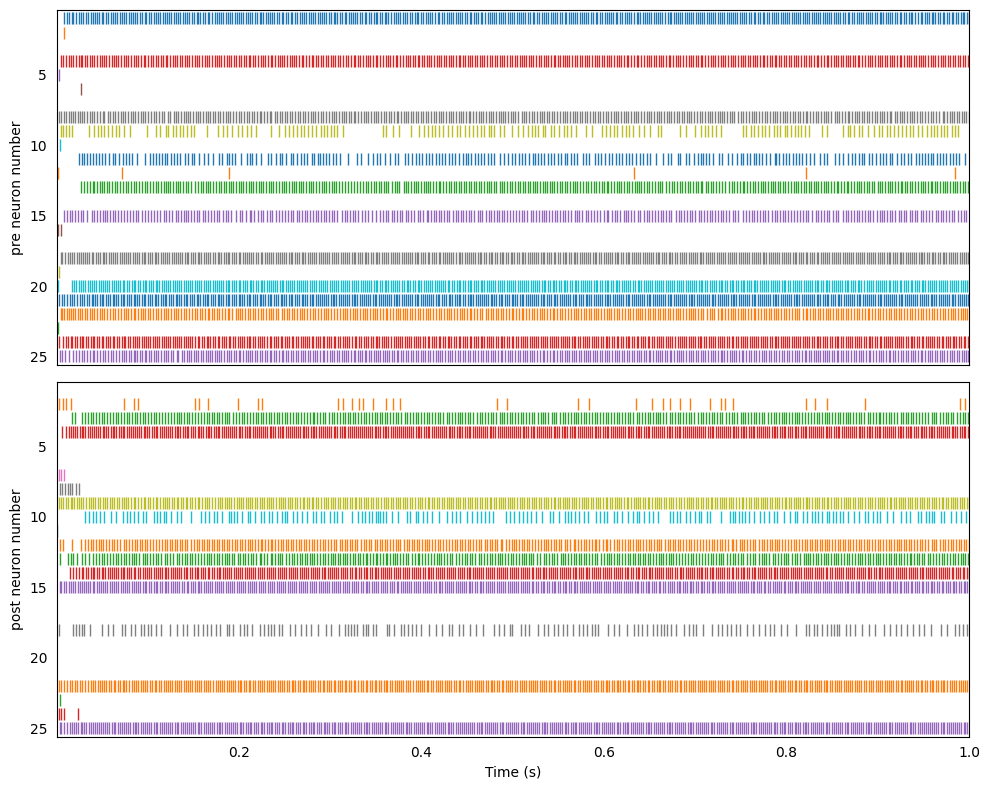

In [13]:
with nengo.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()
plot_rasters(t, sim.data)

## **Running the network with NengoLoihi**

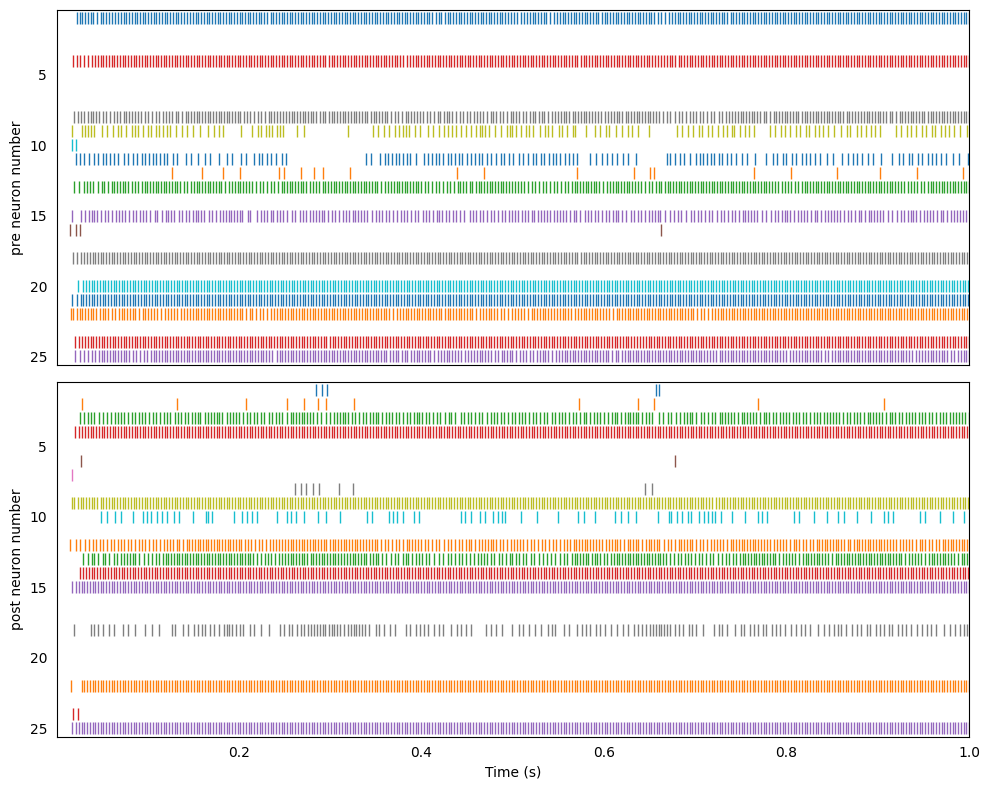

In [14]:
with nengo_loihi.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()
plot_rasters(t, sim.data)